In [1]:
# loading the TER label dictionary
itol_language = {0: 'surprise', 1: 'fear', 2: 'neutral', 3: 'sad', 4: 'happy', 5: 'anger', 6: 'disgust'}
# Loading the FER label dictionary
itol_FER = {0: 'anger', 1: 'sad', 2: 'surprise', 3: 'disgust', 4: 'happy', 5: 'neutral', 6: 'fear'}

In [2]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 1. Defining the language model and attributes

In [3]:
import torch
import torch.nn as nn
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

input_dim = 768
hidden_dim = 128
output_dim = 7
num_layers = 1

language_model = LSTMClassifier(input_dim, hidden_dim, output_dim, num_layers)
language_model.to(device)

LSTMClassifier(
  (lstm): LSTM(768, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=7, bias=True)
)

In [4]:
!git clone https://github.com/Bhattars1/MSc-Project-Expression-Recognition-

Cloning into 'MSc-Project-Expression-Recognition-'...
remote: Enumerating objects: 103, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 103 (delta 37), reused 34 (delta 7), pack-reused 0 (from 0)
Receiving objects: 100% (103/103), 43.10 MiB | 7.24 MiB/s, done.
Resolving deltas: 100% (37/37), done.
Updating files: 100% (31/31), done.


In [5]:
language_model_state_dict = torch.load("MSc-Project-Expression-Recognition-/lstm_model.pth", map_location=torch.device('cpu'))
language_model.load_state_dict(language_model_state_dict)

<ipython-input-5-83e8893609cf>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  language_model_state_dict = torch.load("MSc-Project-Expression-Recognition-/lstm_model.pth", 

<All keys matched successfully>

In [6]:
language_model.eval()

LSTMClassifier(
  (lstm): LSTM(768, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=7, bias=True)
)

## 1.1. Preprocessing function

In [7]:
from transformers import BertTokenizer, BertModel

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [8]:
# Preprocessing function
def generate_bert_embeddings(sentence):
    inputs = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True, max_length=512)
    # Generate embeddings
    with torch.no_grad():
        outputs = model(**inputs)
    # Extract embeddings of the [CLS] token (index 0) for the sentence
    cls_embedding = outputs.last_hidden_state[:, 0, :]
    return cls_embedding.float()

## 1.2. Importing data and preprocessing

In [38]:
# getting the text label dictionary from the dataset instruction
text_labels_dict = {
    0: "no emotion",
    1: "anger",
    2: "disgust",
    3: "fear",
    4: "happiness",
    5: "sadness",
    6: "surprise"
}

In [9]:
import random

# Define file paths
dialogues_text_path = 'MSc-Project-Expression-Recognition-/daily_dialouge/dialogues_text.txt'
dialogues_emotion_path = 'MSc-Project-Expression-Recognition-/daily_dialouge/dialogues_emotion.txt'

# Initialize lists to store sentences and their corresponding labels
sentences = []
labels = []

# Read dialogues from the text file
with open(dialogues_text_path, 'r') as text_file:
    raw_dialogues = text_file.readlines()

# Read labels from the emotion file
with open(dialogues_emotion_path, 'r') as label_file:
    raw_labels = label_file.readlines()

# Process each dialogue and corresponding label
for dialogue, label in zip(raw_dialogues, raw_labels):
    # Split the dialogue into individual sentences (utterances)
    utterances = dialogue.strip().split(" __eou__ ")

    # Split the label line into individual emotion labels
    label_list = list(map(int, label.strip().split()))

    # Append each cleaned sentence and its corresponding label to the lists
    for utterance, label in zip(utterances, label_list):
        cleaned_utterance = utterance.replace('__eou__', '').strip()  # Remove '__eou__' and trim spaces
        if cleaned_utterance:  # Only add if the utterance is not empty
            sentences.append(cleaned_utterance)
            labels.append(label)

print(len(sentences), len(labels))

102979 102979


In [33]:
import random

# Create a dictionary to store sentences by category
category_sentences = {key: [] for key in range(7)}

# Populate the dictionary with sentences by category
for sentence, label in zip(sentences, labels):
    if label in category_sentences and 30 <= len(sentence) <= 120:  # Filter sentences by length
        category_sentences[label].append(sentence)

# Sample 19 items per category
sample_data = []
sample_labels = []

for category, cat_sentences in category_sentences.items():
    if len(cat_sentences) >= 19:
        sampled_sentences = random.sample(cat_sentences, 19)
        sample_data.extend(sampled_sentences)
        sample_labels.extend([category] * 19)
    else:
        print(f"Warning: Not enough samples for category {category}")

print(len(sample_data), len(sample_labels))

133 133


In [42]:
sample_data[101], text_labels_dict[sample_labels[101]]

('You know our boss always trying to save the last penny . We have to use up the equipment first .',
 'sadness')

In [43]:
from collections import Counter
Counter(sample_labels)

Counter({0: 19, 1: 19, 2: 19, 3: 19, 4: 19, 5: 19, 6: 19})

# 2. Defining the FER model and attributes

In [13]:
# Creating an instance of model
import torch
import torch.nn as nn
# Define the model
class TinyVGG(nn.Module):
    def __init__(self, conv1_channels=32, conv2_channels=64, fc1_units=128, dropout_rate=0.5, num_classes=7):
        super(TinyVGG, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, conv1_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(conv1_channels, conv2_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(conv2_channels * 16 * 16, fc1_units),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(fc1_units, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.reshape(x.size(0), -1)
        x = self.classifier(x)
        return x

# Create an instance of the model
TinyVGG_model = TinyVGG(conv1_channels=64, conv2_channels = 64, fc1_units=256, dropout_rate=0.5 ).to(device)
TinyVGG_model = TinyVGG_model.to(dtype=torch.float32)

In [14]:
TinyVGG_model_state_dict = torch.load("MSc-Project-Expression-Recognition-/TinyVGG.pth",map_location=torch.device(device))
TinyVGG_model.load_state_dict(TinyVGG_model_state_dict)

<ipython-input-14-64c01215381d>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  TinyVGG_model_state_dict = torch.load("MSc-Project-Expression-Recognition-/TinyVGG.pth",map_

<All keys matched successfully>

In [15]:
TinyVGG_model.eval()

TinyVGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=16384, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=7, bias=True)
  )
)

## 2.1. Preprocessing function

In [16]:
# Cropping out the face using opencv model (Face detcetion)
import cv2
# Load the pre-trained Haar Cascade classifier
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
from google.colab.patches import cv2_imshow as image_show
import numpy as np

In [17]:
def image_crop(image):
    # Convert image to numpy array if it's not already
    image = np.array(image)

    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_image = gray_image.astype(np.uint8)

    # Perform face detection
    faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Check if at least one face is detected
    if len(faces) > 0:
        # Crop the face from the image (taking the first detected face)
        x, y, w, h = faces[0]
        cropped_face = image[y:y+h, x:x+w]
        return cropped_face

    # Return None if no face is detected
    return "No Face Detected!!!"

In [18]:
# Histogram Equalization using CLAHE and normalization
def clahe_func_normalization(image, clip_limit=2.0, grid_size=4):

    # Convert image to LAB color space
    lab_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)

    # Split the LAB image into its channels
    l_channel, a_channel, b_channel = cv2.split(lab_image)

    # Apply CLAHE to the L channel
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(grid_size, grid_size))
    cl_l_channel = clahe.apply(l_channel)

    # Merge the CLAHE enhanced L channel back with A and B channels
    merged_lab_image = cv2.merge((cl_l_channel, a_channel, b_channel))

    # Convert the LAB image back to RGB color space
    clahe_image = cv2.cvtColor(merged_lab_image, cv2.COLOR_LAB2RGB)

    # Normalize the final image to the 0-1 range
    final_normalized_image = clahe_image / 255.0

    return final_normalized_image

In [19]:
# resizing the image and converting to the tensor
def resize_image(image, size=64):
    # Resize the image to the specified size
    resized_image = cv2.resize(image, (size, size))
    return resized_image
def to_tensor(image):
    tensor_image = torch.tensor(image).float()
    return tensor_image

In [20]:
# Preprocessing pipeline
def preprocessing_pipeline(image):
  image = image_crop(image)
  image = clahe_func_normalization(image)
  image = resize_image(image)
  image = to_tensor(image)
  return image

## 2.4. Import data

In [21]:
# Mounting the drive to import dataset
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [22]:
# Importing necessary libraries to import the images
from tqdm.auto import tqdm
import os
from PIL import Image

# Set up the path to the new dataset
dataset_path = '/content/drive/MyDrive/gender/new test data/data'


# Initialize lists to store images and labels
images_list = []
labels_list = []

# Initialize dictionary to store label indices and labels
label_dict = {}

# Load images from each class folder
class_idx = 0

# Iterate over class folders
for class_name in tqdm(os.listdir(dataset_path)):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):

        # Assign label index
        label_dict[class_idx] = class_name

        # Iterate over image files in class folder
        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)
            if os.path.isfile(img_path):

                # Load image and apply transformation
                image = Image.open(img_path)
                # Append image and label to respective lists
                images_list.append(image)
                labels_list.append(class_idx)
        class_idx += 1

# Display the number of images loaded for each class
print("Number of classes:", class_idx)
print("Total number of images:", len(images_list))

  0%|          | 0/8 [00:00<?, ?it/s]

Number of classes: 8
Total number of images: 152


## 2.5. Data filtering

In [23]:
# Removing the Contempt images


# Filter images and labels to remove those with the 'Contempt' label
filtered_images_list = []
filtered_labels_list = []

for img, lbl in zip(images_list, labels_list):
    if label_dict[lbl] != 'Contempt':
        filtered_images_list.append(img)
        filtered_labels_list.append(lbl)

# Adjust the label_dict to remove 'Contempt' and re-index starting from zero
filtered_label_dict = {}
label_mapping = {}
new_index = 0

for key, value in label_dict.items():
    if value != 'Contempt':
        label_mapping[key] = new_index
        filtered_label_dict[new_index] = value
        new_index += 1

# Map the filtered labels to the new label indices
filtered_labels_list = [label_mapping[label] for label in filtered_labels_list]

# Output the results
print("Filtered Images List Length:", len(filtered_images_list))
print("Filtered Labels List Length:", len(filtered_labels_list))
print("Filtered Label Dict:", filtered_label_dict)

Filtered Images List Length: 133
Filtered Labels List Length: 133
Filtered Label Dict: {0: 'happy', 1: 'disgust', 2: 'sad', 3: 'fear', 4: 'neutral', 5: 'surprised', 6: 'angry'}


In [24]:
from collections import Counter
Counter(filtered_labels_list)

Counter({0: 19, 1: 19, 2: 19, 3: 19, 4: 19, 5: 19, 6: 19})

# 3. Decision Fusion

## 3.1. Label consistency

There is a lot of label incosistency in the language TER, FER, and the test datasets (both image and text). Thus, careful steps need to be taken to ensure the labels are consistent. For that, first the dataset labels will be taken to make them consistent, then the models outputs will be mapped to the dataset labels dictionary in the prediction function

In [25]:
# First check the inconsistencies
print(filtered_label_dict)
print(text_labels_dict)
print(itol_FER)
print(itol_language)

{0: 'happy', 1: 'disgust', 2: 'sad', 3: 'fear', 4: 'neutral', 5: 'surprised', 6: 'angry'}
{0: 'no emotion', 1: 'anger', 2: 'disgust', 3: 'fear', 4: 'happiness', 5: 'sadness', 6: 'surprise'}
{0: 'anger', 1: 'sad', 2: 'surprise', 3: 'disgust', 4: 'happy', 5: 'neutral', 6: 'fear'}
{0: 'surprise', 1: 'fear', 2: 'neutral', 3: 'sad', 4: 'happy', 5: 'anger', 6: 'disgust'}


In [26]:
# the text labels will be changed according to image labels
# Creating the reverse mapping
reverse_mapping = {
    0: 4,  # 'no emotion' -> 'neutral'
    1: 6,  # 'anger' -> 'angry'
    2: 1,  # 'disgust' -> 'disgust'
    3: 3,  # 'fear' -> 'fear'
    4: 0,  # 'happiness' -> 'happy'
    5: 2,  # 'sadness' -> 'sad'
    6: 5   # 'surprise' -> 'surprised'
}
# Convert sample_labels using the reverse mapping
converted_text_labels = [reverse_mapping[label] for label in sample_labels]

In [27]:
# Defining the prediction function for FER along with the mapping to datasets
mapping_FER = {
    0: 6,  # 'anger' -> 'angry'
    1: 2,  # 'sad' -> 'sad'
    2: 5,  # 'surprise' -> 'surprised'
    3: 1,  # 'disgust' -> 'disgust'
    4: 0,  # 'happy' -> 'happy'
    5: 4,  # 'neutral' -> 'neutral'
    6: 3   # 'fear' -> 'fear'
}

# Prediction function
def predict_FER(image):
    # Preprocess the image
    image = preprocessing_pipeline(image)

    with torch.inference_mode():
        # Get prediction logits
        pred_logits = TinyVGG_model(image.permute(2, 0, 1).unsqueeze(dim=0).to(torch.float32).to(device))

        # Get the prediction probabilities for our samples
        pred_probs = torch.softmax(pred_logits, dim=1)

        # Get the original predicted class index
        pred_class_idx = pred_probs.argmax(dim=1).item()

        # Map to the filtered label index
        mapped_class_idx = mapping_FER[pred_class_idx]

        # Get the corresponding label from filtered_label_dict
        label = filtered_label_dict[pred_class_idx]

    return label, mapped_class_idx, pred_probs

In [28]:
# Mapping for language model
mapping_TER = {
    0: 5,  # 'surprise' -> 'surprise'
    1: 3,  # 'fear' -> 'fear'
    2: 4,  # 'neutral' -> 'neutral'
    3: 2,  # 'sad' -> 'sad'
    4: 0,  # 'happy' -> 'happy'
    5: 6,  # 'anger' -> 'angry'
    6: 1   # 'disgust' -> 'disgust'
}

# Defining prediction function for TER along with the mapping to dataset and making it consistent

# Prediction function
def predict_text_expression(text):

  # Embedding the text using BERT
  embedded_text = generate_bert_embeddings(text).to(device)

  # stop gradient tracking
  with torch.inference_mode():

    # Make the prediction
    logits = language_model(embedded_text.unsqueeze(0))

    # Get the probs and labels
    probs = torch.softmax(logits, dim=1).squeeze()
    label = mapping_TER[probs.argmax(0).item()]

    # Return
    return filtered_label_dict[label], label, probs

## 3.2. Perparing the fusion Data

In [48]:
# Check for the data count
Counter(converted_text_labels), Counter(filtered_labels_list)

(Counter({4: 19, 6: 19, 1: 19, 3: 19, 0: 19, 2: 19, 5: 19}),
 Counter({0: 19, 1: 19, 2: 19, 3: 19, 4: 19, 5: 19, 6: 19}))

In [49]:
# Making a tuple list of image and text to feed to decision fusion model

# Initialize lists to hold the result
tuples_list = []
labels_list = filtered_labels_list
# Create tuples (image, text) for each label
for img, txt in zip(filtered_images_list, sample_data):
    tuples_list.append((img, txt))

In [50]:
len(labels_list), len(tuples_list)

(133, 133)

### 3.2.1 Visualizing the fused data

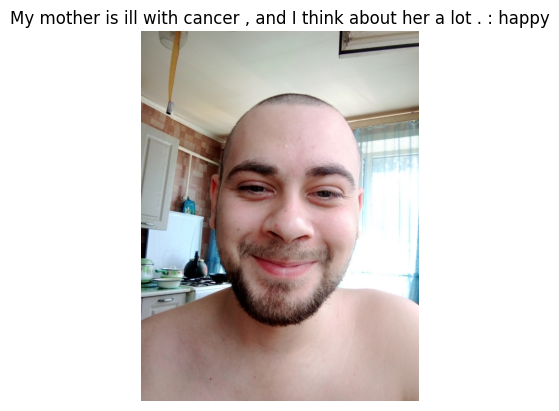

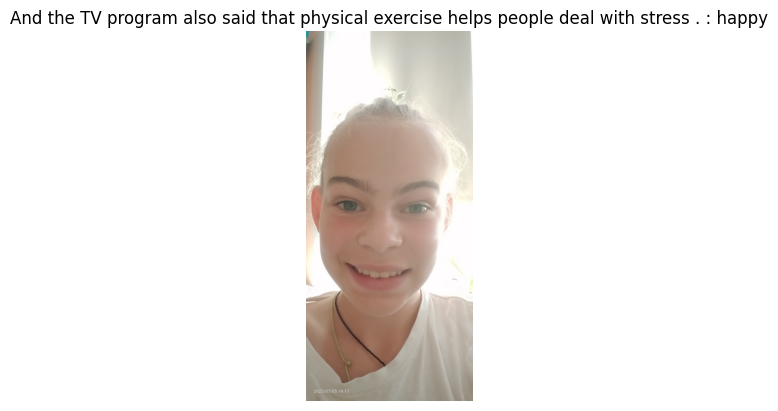

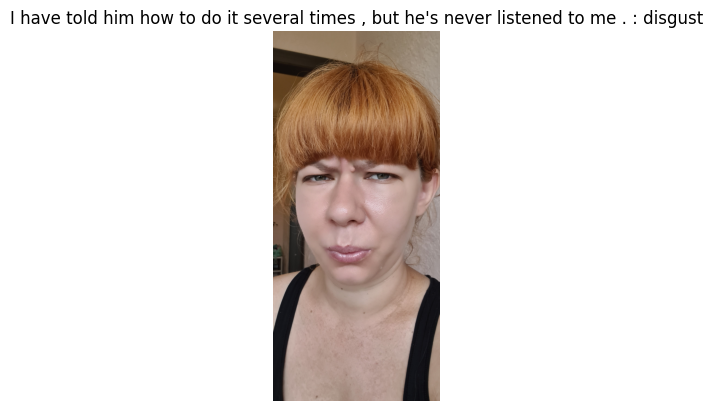

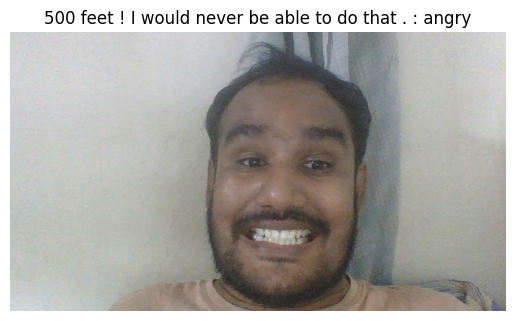

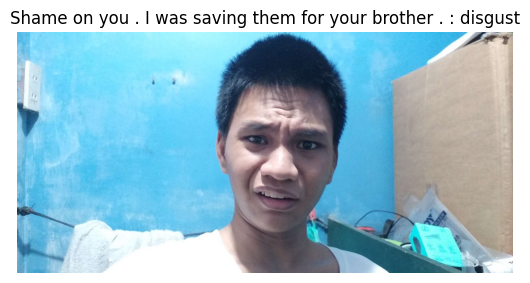

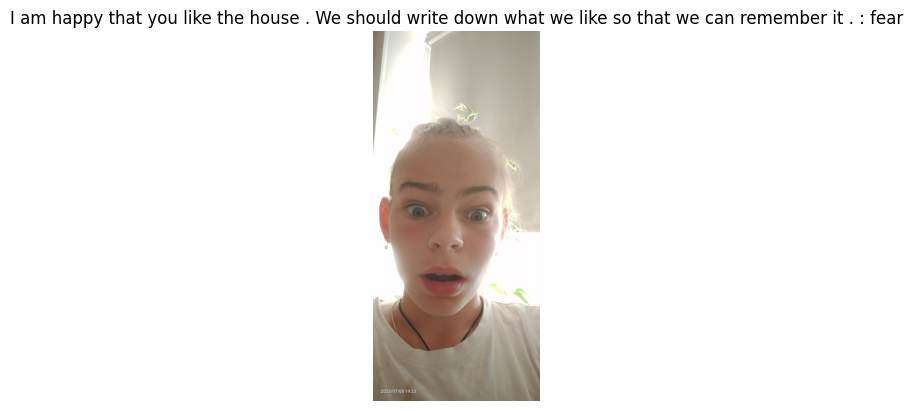

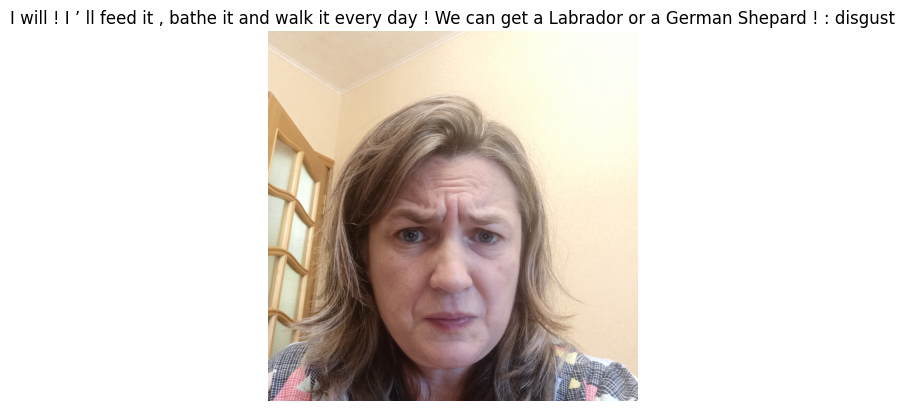

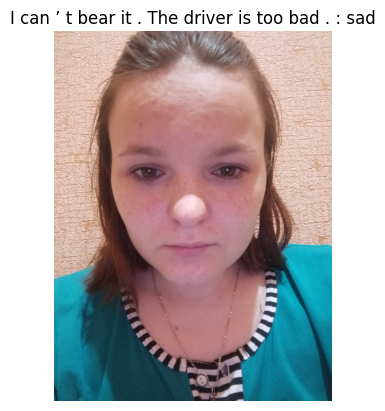

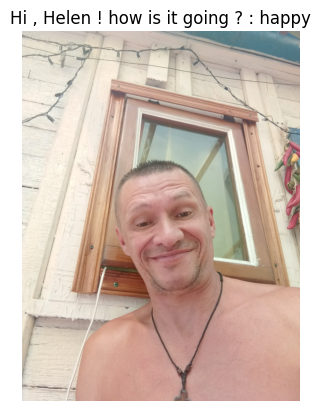

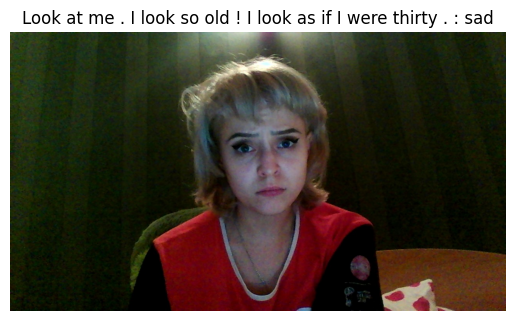

In [51]:
# Checking images and text
random_indices = random.sample(range(len(tuples_list)), 10)
import matplotlib.pyplot as plt
for idx, i in enumerate(random_indices):
  image, text = tuples_list[i]
  plt.imshow(image)
  plt.title(f"{text} : {filtered_label_dict[labels_list[i]]}")
  plt.axis('off')
  plt.show();

## 3.3. Decision Fusion version 1

In [60]:
# Defining Decision Fusion Function

def fusion_prediction(data, language_model=language_model, FER_model=TinyVGG_model, language_model_weight=39, FER_model_weight=52):
    with torch.inference_mode():
        # Unpack the data
        image, text = data

        # Make predictions
        language_label, language_label_item, language_probs = predict_text_expression(text)
        FER_label, FER_label_item, FER_probs = predict_FER(image)

        # Calculate the fusion predictions
        fusion_probs = (language_probs * language_model_weight + FER_probs.squeeze() * FER_model_weight) / (language_model_weight + FER_model_weight)

        fusion_label_item = fusion_probs.argmax(dim=0).item()
        fusion_label = filtered_label_dict[fusion_label_item]

        # Return
        return fusion_label, fusion_label_item, fusion_probs, language_label, language_label_item, language_probs, FER_label, FER_label_item, FER_probs

In [61]:
from sklearn.metrics import accuracy_score

# Compute accuray of fusion and individual model
def combined_accuracy_fn(true_labels, predicted_fusion_labels, predicted_language_labels,predicted_FER_labels):
    # Calculate accuracy for each model
    fusion_accuracy = accuracy_score(true_labels, predicted_fusion_labels)
    language_accuracy = accuracy_score(true_labels, predicted_language_labels)
    FER_accuracy = accuracy_score(true_labels, predicted_FER_labels)

    return fusion_accuracy, language_accuracy, FER_accuracy

In [62]:
# Make predictions function on data and compute accuracy
def prediction_loop(dataset = tuples_list, labels = labels_list,  batch_size = 8, fusion_prediction=fusion_prediction):
  predicted_fusion_labels = []
  predicted_language_labels = []
  predicted_FER_labels = []
  for i in tqdm(range(0, len(dataset), batch_size)):
      batch = dataset[i:i + batch_size]
      for data in batch:
          _,fusion_pred,_,_,language_pred,_,_,FER_pred,_= fusion_prediction(data, language_model_weight=1, FER_model_weight=1)
          predicted_fusion_labels.append(fusion_pred)
          predicted_language_labels.append(language_pred)
          predicted_FER_labels.append(FER_pred)
  fusion_accuracy, language_accuracy, FER_accuracy = combined_accuracy_fn(labels, predicted_fusion_labels, predicted_language_labels, predicted_FER_labels)
  return predicted_fusion_labels, predicted_language_labels, predicted_FER_labels, fusion_accuracy, language_accuracy, FER_accuracy

In [63]:
predicted_fusion_labels, predicted_language_labels, predicted_FER_labels, fusion_accuracy, language_accuracy, FER_accuracy = prediction_loop()

  0%|          | 0/17 [00:00<?, ?it/s]

In [66]:
print(f"Fusion Accuracy: {fusion_accuracy*100:.2f}%")
print(f"Language Accuracy: {language_accuracy*100:.2f}%")
print(f"FER Accuracy: {FER_accuracy*100:.2f}%")

Fusion Accuracy: 12.03%
Language Accuracy: 18.80%
FER Accuracy: 49.62%


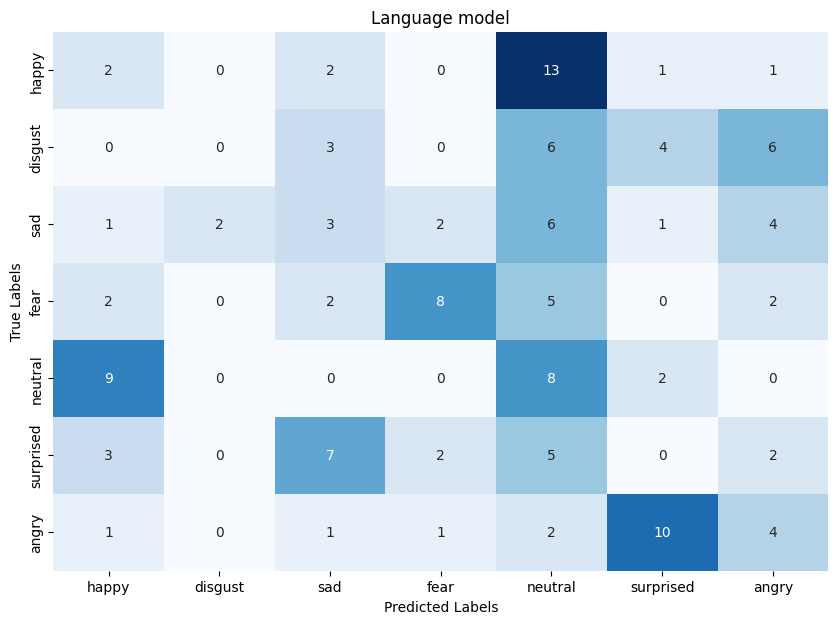

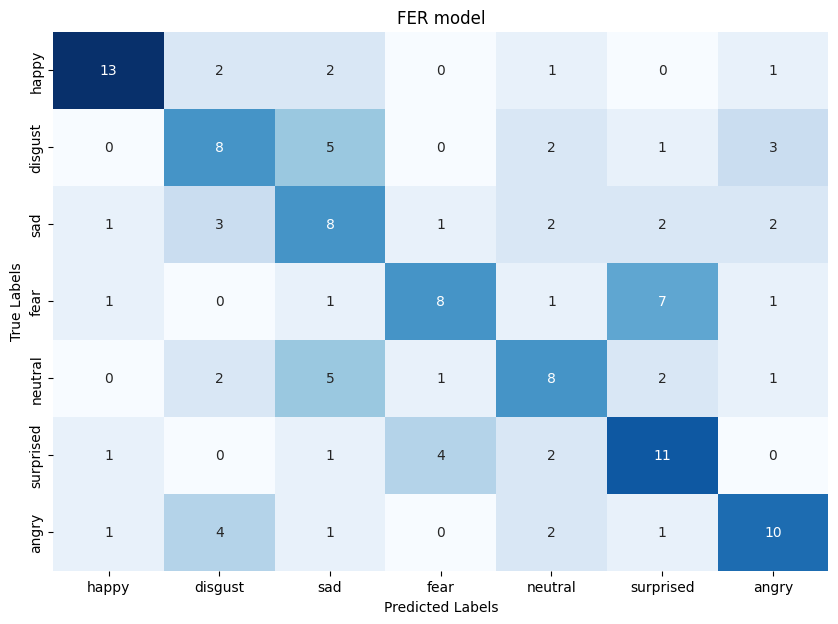

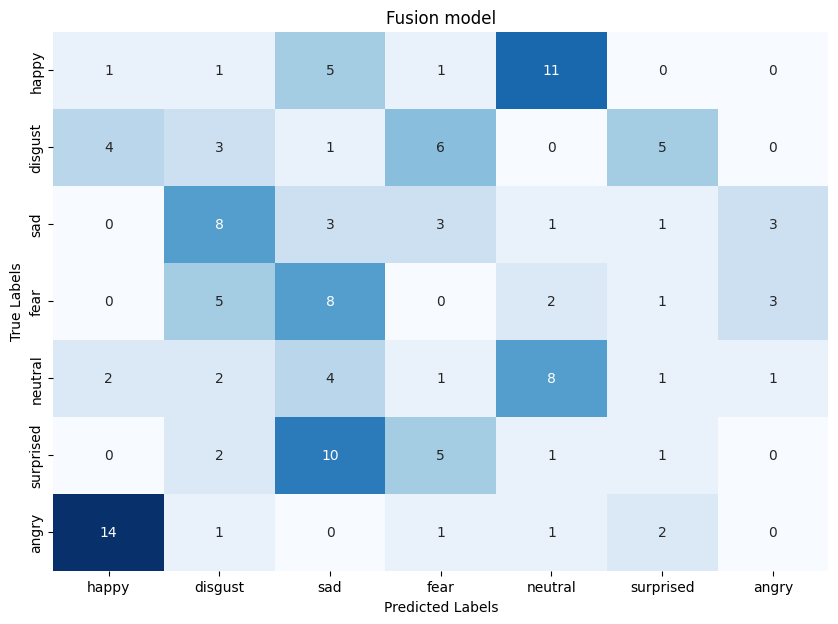

In [67]:
# plotting confusion matrix

from sklearn.metrics import confusion_matrix

import seaborn as sns
import pandas as pd

# Define confusion matrix function
def generate_confusion_matrix(labels, predicted_labels, label_dict=filtered_label_dict, title = "Confusion Matrix"):

  # Generate Confusion Matrix
  conf_matrix = confusion_matrix(labels, predicted_labels, labels=list(label_dict.keys()))
  conf_matrix_df = pd.DataFrame(conf_matrix, index=[label_dict[i] for i in label_dict.keys()], columns=[label_dict[i] for i in label_dict.keys()])

  # Plot Confusion Matrix
  plt.figure(figsize=(10, 7))
  sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', cbar=False)
  plt.title(title)
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.show();

generate_confusion_matrix(labels_list, predicted_language_labels, title = "Language model")
generate_confusion_matrix(labels_list, predicted_FER_labels, title = "FER model")
generate_confusion_matrix(labels_list, predicted_fusion_labels, title = "Fusion model")


## 3.4. Decision Fusion version 2

In [68]:
# Confidence thresholding and Confidence-Based Weight Adjustment fusion model using
def fusion_prediction_v2(
    data,
    language_model=language_model,
    FER_model=TinyVGG_model,
    language_model_weight=39,
    FER_model_weight=52,
    confidence_threshold=0.4,
    distrust_factor=0.1
):
    with torch.inference_mode():
        # Unpack the data
        image, text = data

        # Make predictions
        language_label, language_label_item, language_probs = predict_text_expression(text)
        FER_label, FER_label_item, FER_probs = predict_FER(image)

        # Calculate max confidence for each model
        language_max_confidence = language_probs.max(dim=0)[0].item()
        FER_max_confidence = FER_probs.max(dim=1)[0].item()
        # Adjust model weights based on confidence
        if language_max_confidence < confidence_threshold:
            language_model_weight *= distrust_factor

        if FER_max_confidence < confidence_threshold:
            FER_model_weight *= distrust_factor

        # Calculate the fusion predictions
        fusion_probs = (
            language_probs * language_model_weight + FER_probs * FER_model_weight
        ) / (language_model_weight + FER_model_weight)

        fusion_label_item = fusion_probs.argmax(dim=1).item()
        fusion_label = filtered_label_dict[fusion_label_item]

        return fusion_label, fusion_label_item, fusion_probs, language_label, language_label_item, language_probs, FER_label, FER_label_item, FER_probs

In [70]:
predicted_fusion_labels, predicted_language_labels, predicted_FER_labels, fusion_accuracy, language_accuracy, FER_accuracy = prediction_loop(fusion_prediction = fusion_prediction_v2)

  0%|          | 0/17 [00:00<?, ?it/s]

In [71]:
print(f"Fusion Accuracy V2: {fusion_accuracy*100:.2f}%")
print(f"Language Accuracy: {language_accuracy*100:.2f}%")
print(f"FER Accuracy: {FER_accuracy*100:.2f}%")

Fusion Accuracy V2: 12.03%
Language Accuracy: 18.80%
FER Accuracy: 49.62%


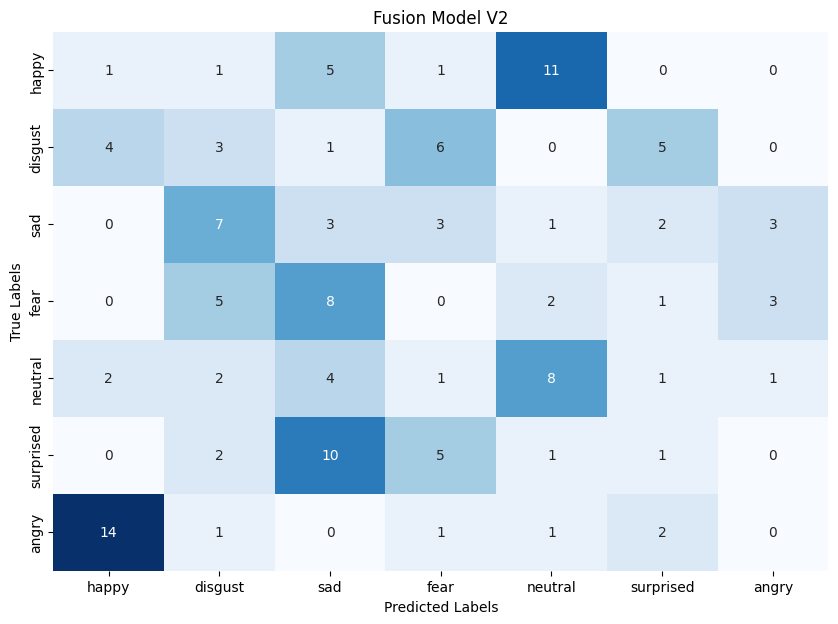

In [72]:
generate_confusion_matrix(labels_list, predicted_fusion_labels, title = "Fusion Model V2")